# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3883008/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:45 - loss: 0.6951

  25/1875 [..............................] - ETA: 3s - loss: 0.5715   

  50/1875 [..............................] - ETA: 3s - loss: 0.4894

  74/1875 [>.............................] - ETA: 3s - loss: 0.4463

 101/1875 [>.............................] - ETA: 3s - loss: 0.4151

 131/1875 [=>............................] - ETA: 3s - loss: 0.3912

 163/1875 [=>............................] - ETA: 3s - loss: 0.3721

 196/1875 [==>...........................] - ETA: 3s - loss: 0.3567

 228/1875 [==>...........................] - ETA: 2s - loss: 0.3445

 258/1875 [===>..........................] - ETA: 2s - loss: 0.3347

 284/1875 [===>..........................] - ETA: 2s - loss: 0.3273

 315/1875 [====>.........................] - ETA: 2s - loss: 0.3193

 347/1875 [====>.........................] - ETA: 2s - loss: 0.3120

 377/1875 [=====>........................] - ETA: 2s - loss: 0.3058

 407/1875 [=====>........................] - ETA: 2s - loss: 0.3002

 441/1875 [======>.......................] - ETA: 2s - loss: 0.2943

 471/1875 [======>.......................] - ETA: 2s - loss: 0.2896

 505/1875 [=======>......................] - ETA: 2s - loss: 0.2847

 541/1875 [=======>......................] - ETA: 2s - loss: 0.2798

 570/1875 [========>.....................] - ETA: 2s - loss: 0.2762

 595/1875 [========>.....................] - ETA: 2s - loss: 0.2733

 621/1875 [========>.....................] - ETA: 2s - loss: 0.2703

 650/1875 [=========>....................] - ETA: 2s - loss: 0.2672

 679/1875 [=========>....................] - ETA: 2s - loss: 0.2643

 707/1875 [==========>...................] - ETA: 2s - loss: 0.2616

 736/1875 [==========>...................] - ETA: 1s - loss: 0.2589

 765/1875 [===========>..................] - ETA: 1s - loss: 0.2564

 794/1875 [===========>..................] - ETA: 1s - loss: 0.2540

 824/1875 [============>.................] - ETA: 1s - loss: 0.2516

 849/1875 [============>.................] - ETA: 1s - loss: 0.2496

 877/1875 [=============>................] - ETA: 1s - loss: 0.2476

 902/1875 [=============>................] - ETA: 1s - loss: 0.2458

 928/1875 [=============>................] - ETA: 1s - loss: 0.2440

 957/1875 [==============>...............] - ETA: 1s - loss: 0.2420

 985/1875 [==============>...............] - ETA: 1s - loss: 0.2402

1014/1875 [===============>..............] - ETA: 1s - loss: 0.2384

1044/1875 [===============>..............] - ETA: 1s - loss: 0.2366

1075/1875 [================>.............] - ETA: 1s - loss: 0.2348

1105/1875 [================>.............] - ETA: 1s - loss: 0.2331

1135/1875 [=================>............] - ETA: 1s - loss: 0.2315

1167/1875 [=================>............] - ETA: 1s - loss: 0.2299

1205/1875 [==================>...........] - ETA: 1s - loss: 0.2279

1228/1875 [==================>...........] - ETA: 1s - loss: 0.2268

1257/1875 [===================>..........] - ETA: 1s - loss: 0.2254

1284/1875 [===================>..........] - ETA: 1s - loss: 0.2242

1315/1875 [====================>.........] - ETA: 0s - loss: 0.2228

1345/1875 [====================>.........] - ETA: 0s - loss: 0.2215

1366/1875 [====================>.........] - ETA: 0s - loss: 0.2206

1394/1875 [=====================>........] - ETA: 0s - loss: 0.2194

1417/1875 [=====================>........] - ETA: 0s - loss: 0.2185

1440/1875 [======================>.......] - ETA: 0s - loss: 0.2175

1471/1875 [======================>.......] - ETA: 0s - loss: 0.2163

1492/1875 [======================>.......] - ETA: 0s - loss: 0.2155

1518/1875 [=======================>......] - ETA: 0s - loss: 0.2145

1540/1875 [=======================>......] - ETA: 0s - loss: 0.2137

1566/1875 [========================>.....] - ETA: 0s - loss: 0.2128

1591/1875 [========================>.....] - ETA: 0s - loss: 0.2119

1620/1875 [========================>.....] - ETA: 0s - loss: 0.2109

1646/1875 [=========================>....] - ETA: 0s - loss: 0.2100

1674/1875 [=========================>....] - ETA: 0s - loss: 0.2091

1701/1875 [==========================>...] - ETA: 0s - loss: 0.2082

1730/1875 [==========================>...] - ETA: 0s - loss: 0.2073

1758/1875 [===========================>..] - ETA: 0s - loss: 0.2064

1787/1875 [===========================>..] - ETA: 0s - loss: 0.2055

1816/1875 [============================>.] - ETA: 0s - loss: 0.2046

1843/1875 [============================>.] - ETA: 0s - loss: 0.2039

1872/1875 [============================>.] - ETA: 0s - loss: 0.2030

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2029


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1060

  29/1875 [..............................] - ETA: 3s - loss: 0.1073

  57/1875 [..............................] - ETA: 3s - loss: 0.1087

  86/1875 [>.............................] - ETA: 3s - loss: 0.1092

 111/1875 [>.............................] - ETA: 3s - loss: 0.1092

 138/1875 [=>............................] - ETA: 3s - loss: 0.1092

 165/1875 [=>............................] - ETA: 3s - loss: 0.1092

 193/1875 [==>...........................] - ETA: 3s - loss: 0.1092

 222/1875 [==>...........................] - ETA: 3s - loss: 0.1092

 250/1875 [===>..........................] - ETA: 2s - loss: 0.1091

 279/1875 [===>..........................] - ETA: 2s - loss: 0.1091

 309/1875 [===>..........................] - ETA: 2s - loss: 0.1090

 334/1875 [====>.........................] - ETA: 2s - loss: 0.1089

 360/1875 [====>.........................] - ETA: 2s - loss: 0.1089

 385/1875 [=====>........................] - ETA: 2s - loss: 0.1088

 416/1875 [=====>........................] - ETA: 2s - loss: 0.1087

 446/1875 [======>.......................] - ETA: 2s - loss: 0.1087

 467/1875 [======>.......................] - ETA: 2s - loss: 0.1086

 495/1875 [======>.......................] - ETA: 2s - loss: 0.1085

 516/1875 [=======>......................] - ETA: 2s - loss: 0.1085

 543/1875 [=======>......................] - ETA: 2s - loss: 0.1084

 573/1875 [========>.....................] - ETA: 2s - loss: 0.1083

 603/1875 [========>.....................] - ETA: 2s - loss: 0.1083

 633/1875 [=========>....................] - ETA: 2s - loss: 0.1082

 663/1875 [=========>....................] - ETA: 2s - loss: 0.1081

 694/1875 [==========>...................] - ETA: 2s - loss: 0.1080

 720/1875 [==========>...................] - ETA: 2s - loss: 0.1080

 749/1875 [==========>...................] - ETA: 2s - loss: 0.1079

 778/1875 [===========>..................] - ETA: 2s - loss: 0.1079

 806/1875 [===========>..................] - ETA: 1s - loss: 0.1078

 834/1875 [============>.................] - ETA: 1s - loss: 0.1077

 863/1875 [============>.................] - ETA: 1s - loss: 0.1077

 893/1875 [=============>................] - ETA: 1s - loss: 0.1076

 921/1875 [=============>................] - ETA: 1s - loss: 0.1076

 947/1875 [==============>...............] - ETA: 1s - loss: 0.1075

 976/1875 [==============>...............] - ETA: 1s - loss: 0.1075

1006/1875 [===============>..............] - ETA: 1s - loss: 0.1074

1036/1875 [===============>..............] - ETA: 1s - loss: 0.1073

1064/1875 [================>.............] - ETA: 1s - loss: 0.1073

1093/1875 [================>.............] - ETA: 1s - loss: 0.1072

1122/1875 [================>.............] - ETA: 1s - loss: 0.1072

1150/1875 [=================>............] - ETA: 1s - loss: 0.1071

1179/1875 [=================>............] - ETA: 1s - loss: 0.1071

1208/1875 [==================>...........] - ETA: 1s - loss: 0.1070

1237/1875 [==================>...........] - ETA: 1s - loss: 0.1069

1266/1875 [===================>..........] - ETA: 1s - loss: 0.1069

1295/1875 [===================>..........] - ETA: 1s - loss: 0.1068

1323/1875 [====================>.........] - ETA: 1s - loss: 0.1068

1350/1875 [====================>.........] - ETA: 0s - loss: 0.1067

1380/1875 [=====================>........] - ETA: 0s - loss: 0.1067

1403/1875 [=====================>........] - ETA: 0s - loss: 0.1066

1432/1875 [=====================>........] - ETA: 0s - loss: 0.1066

1455/1875 [======================>.......] - ETA: 0s - loss: 0.1066

1482/1875 [======================>.......] - ETA: 0s - loss: 0.1065

1512/1875 [=======================>......] - ETA: 0s - loss: 0.1065

1539/1875 [=======================>......] - ETA: 0s - loss: 0.1064

1568/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1595/1875 [========================>.....] - ETA: 0s - loss: 0.1063

1624/1875 [========================>.....] - ETA: 0s - loss: 0.1063

1653/1875 [=========================>....] - ETA: 0s - loss: 0.1062

1681/1875 [=========================>....] - ETA: 0s - loss: 0.1062

1710/1875 [==========================>...] - ETA: 0s - loss: 0.1061

1739/1875 [==========================>...] - ETA: 0s - loss: 0.1061

1768/1875 [===========================>..] - ETA: 0s - loss: 0.1060

1796/1875 [===========================>..] - ETA: 0s - loss: 0.1060

1823/1875 [============================>.] - ETA: 0s - loss: 0.1059

1849/1875 [============================>.] - ETA: 0s - loss: 0.1059

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1058


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0928

  29/1875 [..............................] - ETA: 3s - loss: 0.0961

  58/1875 [..............................] - ETA: 3s - loss: 0.0968

  86/1875 [>.............................] - ETA: 3s - loss: 0.0972

 114/1875 [>.............................] - ETA: 3s - loss: 0.0975

 141/1875 [=>............................] - ETA: 3s - loss: 0.0976

 166/1875 [=>............................] - ETA: 3s - loss: 0.0977

 193/1875 [==>...........................] - ETA: 3s - loss: 0.0977

 220/1875 [==>...........................] - ETA: 3s - loss: 0.0977

 247/1875 [==>...........................] - ETA: 3s - loss: 0.0977

 275/1875 [===>..........................] - ETA: 2s - loss: 0.0977

 300/1875 [===>..........................] - ETA: 2s - loss: 0.0977

 330/1875 [====>.........................] - ETA: 2s - loss: 0.0978

 359/1875 [====>.........................] - ETA: 2s - loss: 0.0978

 384/1875 [=====>........................] - ETA: 2s - loss: 0.0978

 411/1875 [=====>........................] - ETA: 2s - loss: 0.0978

 440/1875 [======>.......................] - ETA: 2s - loss: 0.0978

 467/1875 [======>.......................] - ETA: 2s - loss: 0.0978

 496/1875 [======>.......................] - ETA: 2s - loss: 0.0978

 524/1875 [=======>......................] - ETA: 2s - loss: 0.0978

 549/1875 [=======>......................] - ETA: 2s - loss: 0.0978

 578/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 606/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 635/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 663/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 691/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 719/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 747/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 773/1875 [===========>..................] - ETA: 2s - loss: 0.0979

 799/1875 [===========>..................] - ETA: 1s - loss: 0.0979

 826/1875 [============>.................] - ETA: 1s - loss: 0.0979

 855/1875 [============>.................] - ETA: 1s - loss: 0.0979

 882/1875 [=============>................] - ETA: 1s - loss: 0.0979

 909/1875 [=============>................] - ETA: 1s - loss: 0.0979

 927/1875 [=============>................] - ETA: 1s - loss: 0.0979

 948/1875 [==============>...............] - ETA: 1s - loss: 0.0979

 976/1875 [==============>...............] - ETA: 1s - loss: 0.0979

1003/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1030/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1059/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1087/1875 [================>.............] - ETA: 1s - loss: 0.0979

1116/1875 [================>.............] - ETA: 1s - loss: 0.0979

1144/1875 [=================>............] - ETA: 1s - loss: 0.0979

1172/1875 [=================>............] - ETA: 1s - loss: 0.0979

1199/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1228/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1257/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1285/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1314/1875 [====================>.........] - ETA: 1s - loss: 0.0978

1342/1875 [====================>.........] - ETA: 0s - loss: 0.0978

1366/1875 [====================>.........] - ETA: 0s - loss: 0.0978

1396/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1426/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1472/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1500/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1523/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1546/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1599/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1663/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1691/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1759/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1823/1875 [============================>.] - ETA: 0s - loss: 0.0978

1854/1875 [============================>.] - ETA: 0s - loss: 0.0977

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0977


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0935

  31/1875 [..............................] - ETA: 3s - loss: 0.0955

  55/1875 [..............................] - ETA: 3s - loss: 0.0964

  82/1875 [>.............................] - ETA: 3s - loss: 0.0966

 112/1875 [>.............................] - ETA: 3s - loss: 0.0967

 144/1875 [=>............................] - ETA: 3s - loss: 0.0968

 174/1875 [=>............................] - ETA: 2s - loss: 0.0968

 204/1875 [==>...........................] - ETA: 2s - loss: 0.0968

 235/1875 [==>...........................] - ETA: 2s - loss: 0.0967

 267/1875 [===>..........................] - ETA: 2s - loss: 0.0967

 297/1875 [===>..........................] - ETA: 2s - loss: 0.0967

 319/1875 [====>.........................] - ETA: 2s - loss: 0.0967

 349/1875 [====>.........................] - ETA: 2s - loss: 0.0967

 374/1875 [====>.........................] - ETA: 2s - loss: 0.0966

 403/1875 [=====>........................] - ETA: 2s - loss: 0.0966

 431/1875 [=====>........................] - ETA: 2s - loss: 0.0966

 459/1875 [======>.......................] - ETA: 2s - loss: 0.0966

 483/1875 [======>.......................] - ETA: 2s - loss: 0.0966

 511/1875 [=======>......................] - ETA: 2s - loss: 0.0965

 539/1875 [=======>......................] - ETA: 2s - loss: 0.0965

 568/1875 [========>.....................] - ETA: 2s - loss: 0.0965

 593/1875 [========>.....................] - ETA: 2s - loss: 0.0965

 621/1875 [========>.....................] - ETA: 2s - loss: 0.0965

 648/1875 [=========>....................] - ETA: 2s - loss: 0.0965

 676/1875 [=========>....................] - ETA: 2s - loss: 0.0965

 704/1875 [==========>...................] - ETA: 2s - loss: 0.0965

 732/1875 [==========>...................] - ETA: 2s - loss: 0.0965

 757/1875 [===========>..................] - ETA: 2s - loss: 0.0965

 780/1875 [===========>..................] - ETA: 2s - loss: 0.0965

 807/1875 [===========>..................] - ETA: 1s - loss: 0.0965

 832/1875 [============>.................] - ETA: 1s - loss: 0.0965

 856/1875 [============>.................] - ETA: 1s - loss: 0.0965

 879/1875 [=============>................] - ETA: 1s - loss: 0.0965

 906/1875 [=============>................] - ETA: 1s - loss: 0.0965

 931/1875 [=============>................] - ETA: 1s - loss: 0.0965

 955/1875 [==============>...............] - ETA: 1s - loss: 0.0965

 980/1875 [==============>...............] - ETA: 1s - loss: 0.0965

1005/1875 [===============>..............] - ETA: 1s - loss: 0.0965

1034/1875 [===============>..............] - ETA: 1s - loss: 0.0965

1056/1875 [===============>..............] - ETA: 1s - loss: 0.0965

1085/1875 [================>.............] - ETA: 1s - loss: 0.0965

1117/1875 [================>.............] - ETA: 1s - loss: 0.0965

1151/1875 [=================>............] - ETA: 1s - loss: 0.0965

1181/1875 [=================>............] - ETA: 1s - loss: 0.0965

1209/1875 [==================>...........] - ETA: 1s - loss: 0.0965

1237/1875 [==================>...........] - ETA: 1s - loss: 0.0965

1264/1875 [===================>..........] - ETA: 1s - loss: 0.0965

1292/1875 [===================>..........] - ETA: 1s - loss: 0.0964

1320/1875 [====================>.........] - ETA: 1s - loss: 0.0964

1355/1875 [====================>.........] - ETA: 0s - loss: 0.0964

1389/1875 [=====================>........] - ETA: 0s - loss: 0.0964

1423/1875 [=====================>........] - ETA: 0s - loss: 0.0964

1456/1875 [======================>.......] - ETA: 0s - loss: 0.0964

1490/1875 [======================>.......] - ETA: 0s - loss: 0.0964

1526/1875 [=======================>......] - ETA: 0s - loss: 0.0964

1561/1875 [=======================>......] - ETA: 0s - loss: 0.0964

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0964

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1685/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1714/1875 [==========================>...] - ETA: 0s - loss: 0.0964

1746/1875 [==========================>...] - ETA: 0s - loss: 0.0964

1775/1875 [===========================>..] - ETA: 0s - loss: 0.0964

1801/1875 [===========================>..] - ETA: 0s - loss: 0.0964

1830/1875 [============================>.] - ETA: 0s - loss: 0.0964

1855/1875 [============================>.] - ETA: 0s - loss: 0.0964

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0964


Epoch 5/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0926

  27/1875 [..............................] - ETA: 3s - loss: 0.0955

  51/1875 [..............................] - ETA: 3s - loss: 0.0954

  75/1875 [>.............................] - ETA: 3s - loss: 0.0955

 100/1875 [>.............................] - ETA: 3s - loss: 0.0957

 130/1875 [=>............................] - ETA: 3s - loss: 0.0959

 158/1875 [=>............................] - ETA: 3s - loss: 0.0960

 184/1875 [=>............................] - ETA: 3s - loss: 0.0961

 211/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 238/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 266/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 297/1875 [===>..........................] - ETA: 2s - loss: 0.0961

 326/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 355/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 383/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 416/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 451/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 484/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 517/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 551/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 585/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 612/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 639/1875 [=========>....................] - ETA: 2s - loss: 0.0960

 667/1875 [=========>....................] - ETA: 2s - loss: 0.0959

 701/1875 [==========>...................] - ETA: 2s - loss: 0.0959

 734/1875 [==========>...................] - ETA: 1s - loss: 0.0959

 768/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 797/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 826/1875 [============>.................] - ETA: 1s - loss: 0.0959

 854/1875 [============>.................] - ETA: 1s - loss: 0.0959

 881/1875 [=============>................] - ETA: 1s - loss: 0.0959

 903/1875 [=============>................] - ETA: 1s - loss: 0.0959

 929/1875 [=============>................] - ETA: 1s - loss: 0.0958

 956/1875 [==============>...............] - ETA: 1s - loss: 0.0958

 984/1875 [==============>...............] - ETA: 1s - loss: 0.0958

1009/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1035/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1062/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1088/1875 [================>.............] - ETA: 1s - loss: 0.0958

1117/1875 [================>.............] - ETA: 1s - loss: 0.0958

1146/1875 [=================>............] - ETA: 1s - loss: 0.0958

1173/1875 [=================>............] - ETA: 1s - loss: 0.0958

1200/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1229/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1258/1875 [===================>..........] - ETA: 1s - loss: 0.0958

1286/1875 [===================>..........] - ETA: 1s - loss: 0.0958

1313/1875 [====================>.........] - ETA: 1s - loss: 0.0958

1341/1875 [====================>.........] - ETA: 0s - loss: 0.0958

1369/1875 [====================>.........] - ETA: 0s - loss: 0.0958

1397/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1424/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1449/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1475/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1502/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1529/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1557/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1584/1875 [========================>.....] - ETA: 0s - loss: 0.0958

1606/1875 [========================>.....] - ETA: 0s - loss: 0.0958

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0957

1731/1875 [==========================>...] - ETA: 0s - loss: 0.0957

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0957

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0957

1817/1875 [============================>.] - ETA: 0s - loss: 0.0957

1840/1875 [============================>.] - ETA: 0s - loss: 0.0957

1867/1875 [============================>.] - ETA: 0s - loss: 0.0957

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0957


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

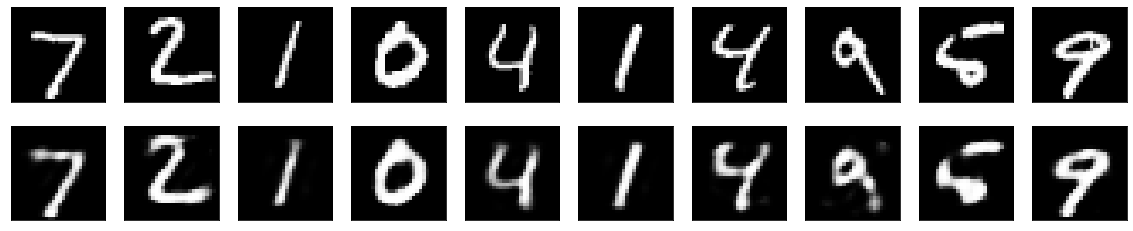

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
